In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
import tensorflow as tf
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import tensorflow.keras.backend as K

In [23]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]
  elif choose == 2: # 6:3:1
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]
  elif choose == 3: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)
 
  return train_data, test_data, val_data

In [24]:

# load the dataset
df = pd.read_csv('/content/drive/MyDrive/IS403.N22/Project/dataset/TSLA_Stock.csv', parse_dates=['Date'], index_col='Date')

# scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

train_data, test_data, val_data = split_data(scaled_data, 1)

Train:  934
Test:  267
Val:  134


In [25]:
# define the number of time steps and features
n_steps = 3
n_features = 1

# Tạo hàm input sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Tạo input sequences cho training, validation, và testing
X_train, y_train = create_sequences(train_data, n_steps)
X_val, y_val = create_sequences(val_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)


In [26]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [27]:
X_train[0]

array([[0.02371621],
       [0.0231635 ],
       [0.02271129]])

In [28]:
X_test[0]

array([[0.60604462],
       [0.58149935],
       [0.58921214]])

In [29]:
# RNN
def RNN():
  model = Sequential()
  model.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, n_features)))
  model.add(Dense(1))

  return model

def LSTM():
  model = Sequential()
  model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(tf.keras.layers.LSTM(50))
  model.add(Dense(1))

  return model

def GRU():
  model = Sequential()
  model.add(tf.keras.layers.GRU(64, input_shape=(n_steps, n_features)))
  model.add(Dense(1))

  return model

In [30]:
model = LSTM()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 3, 50)             10400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')#, metrics=[MeanAbsolutePercentageError()])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
30/30 [==============================] - 6s 47ms/step - loss: 0.0358 - val_loss: 0.0263
Epoch 2/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0064
Epoch 3/100
30/30 [==============================] - 0s 8ms/step - loss: 4.2707e-04 - val_loss: 0.0036
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 3.2009e-04 - val_loss: 0.0035
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 3.0698e-04 - val_loss: 0.0032
Epoch 6/100
30/30 [==============================] - 0s 6ms/step - loss: 3.1892e-04 - val_loss: 0.0028
Epoch 7/100
30/30 [==============================] - 0s 8ms/step - loss: 2.7191e-04 - val_loss: 0.0027
Epoch 8/100
30/30 [==============================] - 0s 7ms/step - loss: 2.6404e-04 - val_loss: 0.0027
Epoch 9/100
30/30 [==============================] - 0s 6ms/step - loss: 2.7253e-04 - val_loss: 0.0024
Epoch 10/100
30/30 [==============================] - 0s 7ms/step - loss: 2.6497

In [32]:
# evaluate trên tập test
loss_test = model.evaluate(X_test, y_test, verbose=0)
print("loss_test: ", loss_test)

# evaluate trên tập val
loss_val = model.evaluate(X_val, y_val, verbose=0)
print("loss_val: ", loss_val)

loss_test:  0.0021229740232229233
loss_val:  0.0005267770611681044


In [33]:
def rmse_mape(true, predict):
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return rmse, mape

In [34]:
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

5/5 [==============================] - 0s 3ms/step


In [35]:

# Chuyển đổi dữ liệu không chuẩn hóa
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
y_val = scaler.inverse_transform(y_val)

In [36]:
rmse_mape(y_test, y_pred_test)

(18.339994289118344, 0.046750281427563635)

In [37]:
rmse_mape(y_val, y_pred_val)

(9.135665044637387, 0.04390669631617899)

In [38]:
number_days = 30

last_sequence = X_val[-1:]

predicted_values = []

for _ in range(number_days):
    next_value = model.predict(last_sequence)
    predicted_values.append(next_value[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [next_value], axis=1)

1/1 [==============================] - 0s 21ms/step


In [39]:
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
predicted_values

array([[175.7821 ],
       [171.74223],
       [168.75496],
       [171.18887],
       [169.33943],
       [168.61613],
       [168.66417],
       [167.75783],
       [167.27415],
       [166.84978],
       [166.24223],
       [165.75981],
       [165.26816],
       [164.75107],
       [164.26929],
       [163.7845 ],
       [163.30186],
       [162.83147],
       [162.36385],
       [161.9019 ],
       [161.44676],
       [160.99632],
       [160.55142],
       [160.11203],
       [159.67763],
       [159.24841],
       [158.8242 ],
       [158.40486],
       [157.99036],
       [157.58058]], dtype=float32)

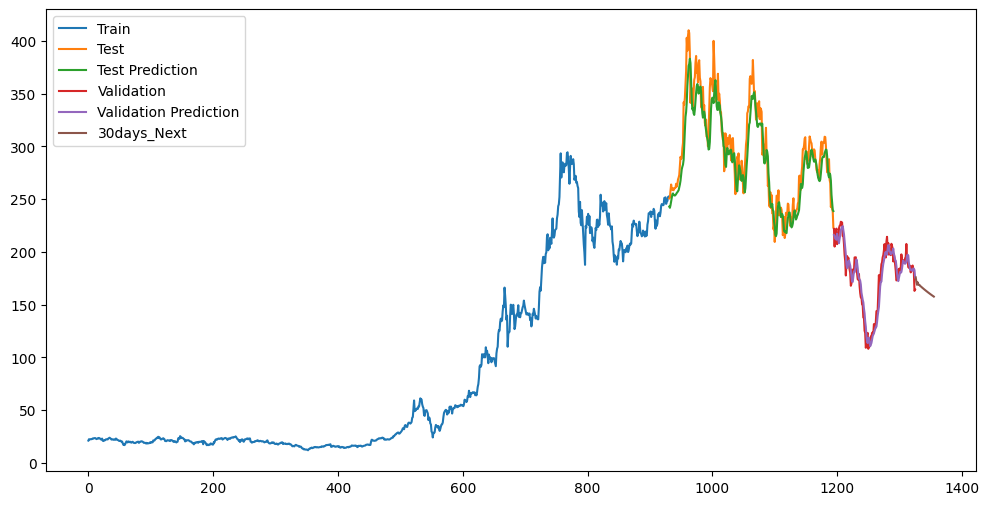

In [40]:
plt.figure(figsize=(12,6))

plt.plot(range(len(y_train)), y_train, label='Train')

plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, label='Test Prediction')

plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_val, label='Validation')
plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_pred_val, label='Validation Prediction')

plt.plot(range(len(y_train) + len(y_test) + len(y_val), len(y_train) + len(y_test) + len(y_val) + number_days), predicted_values, label='30days_Next')

plt.legend()
plt.show()

<ipython-input-41-40f644a24062>:18: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  next30days_offset = pd.date_range(start=dates[-1], periods=31, closed='right')


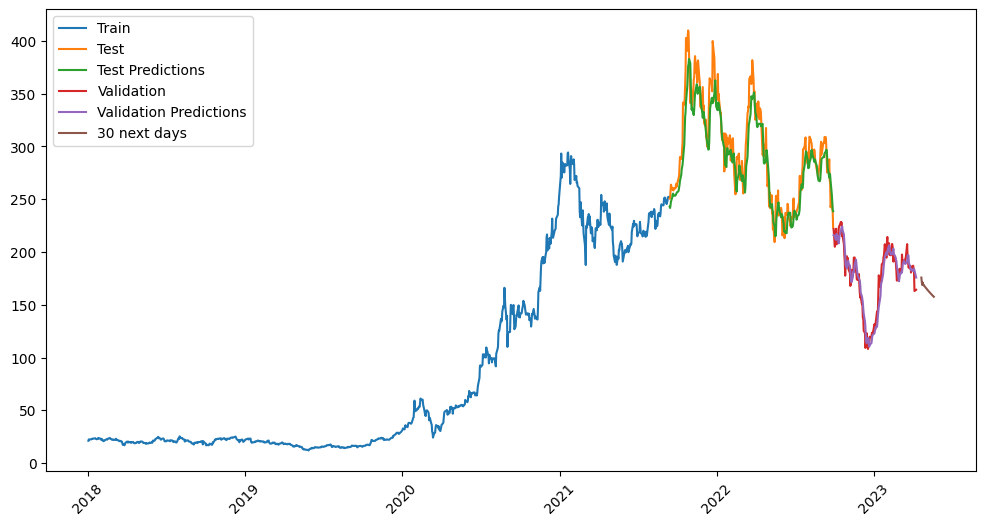

In [41]:
# Create an array of dates for the time steps
dates = df.index

# Plot the training data
plt.figure(figsize=(12, 6))
plt.plot(dates[:len(y_train)], y_train, label='Train')

# Plot the validation data
test_offset = len(y_train)
plt.plot(dates[test_offset:test_offset + len(y_test)], y_test, label='Test')
plt.plot(dates[test_offset:test_offset + len(y_pred_test)], y_pred_test, label='Test Predictions')

# Plot the testing data
val_offset = test_offset + len(y_test)
plt.plot(dates[val_offset:val_offset + len(y_val)], y_val, label='Validation')
plt.plot(dates[val_offset:val_offset + len(y_pred_val)], y_pred_val, label='Validation Predictions')

next30days_offset = pd.date_range(start=dates[-1], periods=31, closed='right')
plt.plot(next30days_offset, predicted_values, label='30 next days')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

plt.legend()
plt.show()